In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from scipy.integrate import solve_ivp
from matplotlib import colors
import pickle
from scipy.signal import find_peaks
from scipy.stats import pearsonr
import HD_utils.circular_stats as cstat
from HD_utils.network import *
from HD_utils.matrix import *
from HD_utils.adap_sim_move import *
from HD_utils.adap_sim_stable import *
from HD_utils.IO import *
from HD_utils.plot import *
from HD_utils.comput_property import *
import warnings

# Parameters Set Up

In [2]:
# Simulation theta precision
theta_num = 50
dtheta = (2*np.pi)/theta_num
theta_range = np.arange(-np.pi+dtheta/2, np.pi, dtheta) # must use np.arange(-np.pi+dtheta/2, np.pi, dtheta) to make it symmetry
# Changeable parameters
ring_num = 3
actfun = max0x
weight_fun = cos_weight_3r_Icos_s
search_pars = {'CI': np.linspace(2,20,10), 'CE': np.linspace(2,20,10), 'LI': np.linspace(0,5,11)}
file_pre_name = '65_3'
# Default parameters
inputs = np.array([-1, -0.6, -0.3, -0.1, 0, 0.1, 0.3, 0.6, 1])
net_diff_equa = net_diff_equa_f_in
alpha = -1/9*np.pi
tau = 20 # ms
bE = 5
bI = 0
# Fixed parameters
par_num = len(search_pars)
search_num = len(ParameterGrid(search_pars))
zeroid = np.where(inputs == 0)[0][0]
par_names = list(search_pars.keys())

# Load Data

In [ ]:
# Run it before the simulation in the current notebook has been saved
Vels, network_eval_moving, network_eval_moving_des, network_acvs_moving, network_ts_moving, network_eval_moving_sum = load_pickle(
    ['moving_slope', 'moving_eval', 'moving_eval_des', 'moving_acvs', 'moving_ts', 'moving_eval_sum'], weight_fun, actfun, file_pre_name)

# Stable

In [ ]:
network_evals, network_evaldes, network_acvs, network_pars, network_ts = load_pickle(
    ['evals', 'eval_des', 'acvs', 'pars', 'ts'], weight_fun, actfun, "63_3_1_copy") # See HD_utils.gridsearch_configs for explanations
valid_index_s = np.where(network_evals == 'valid')[0]
valids_num = len(valid_index_s)

# Moving

In [5]:
# Calculate parameters
rec_t_gap = 20 # should be a factor of 100, and sufficient to calculate velocity
# Initialize store variables
network_eval_moving = np.zeros(( search_num, len(inputs) ), dtype='U30')
network_eval_moving_sum = np.copy(network_evals)
network_vvcor = np.zeros((search_num, ring_num, 2))
network_acvs_moving = np.zeros((search_num, len(inputs)), dtype='object')
network_ts_moving = np.zeros((search_num, len(inputs)), dtype='object')
Vels = np.zeros((search_num, len(inputs), ring_num)) 

for i in tqdm(valid_index_s):
    # parameters and weight ---- Need Change
    w = weight_fun(*network_pars[i], alpha, theta_range)
    # Routine
    s1 = network_acvs[i][:,:,-1].flatten() # Initial state is the stable state in the stationary case
    for ratioi, ratiov in enumerate(inputs):
        bE_change = bE * (1 + abs(ratiov))
        b = steady_inputb_withb0_3r(bE_change, bI, ratiov, theta_num)  # input
        ## Compute network dynamics 
        y, t, network_eval_moving[i,ratioi], Vels[i,ratioi] = inte_check_move(
            net_diff_equa, s1, w, tau, b, theta_num, actfun, rec_t_gap=rec_t_gap)
        ## Store values
        network_acvs_moving[i,ratioi] = np.array([y[:theta_num], y[theta_num:2*theta_num], y[2*theta_num:]])
        network_ts_moving[i,ratioi] = t
    ## Examine
    network_eval_moving[i][zeroid] = 'stable moving'

    network_eval_moving_sum[i] = 'valid stationary shape'
    if np.all(network_eval_moving[i] == 'stable moving'):
        network_vvcor[i] = cal_correlation(inputs, Vels[i])
        network_eval_moving_sum[i] = exam_vv_linearity(network_vvcor[i])

index_check = np.where(network_eval_moving_sum == 'valid stationary shape')[0]
linear_range = check_stamov_range(network_eval_moving, index_check)
network_vvcor, network_eval_moving_sum = check_vv_linearity2(inputs, Vels, linear_range, index_check, network_vvcor, network_eval_moving_sum)

## save simulation result
store_pickle([Vels, network_eval_moving, network_vvcor, network_acvs_moving, network_ts_moving, network_eval_moving_sum], 
             ['moving_slope', 'moving_eval', 'moving_eval_des', 'moving_acvs', 'moving_ts', 'moving_eval_sum'], 
             weight_fun, actfun, file_pre_name)

100%|██████████| 1094/1094 [07:41<00:00,  2.37it/s]


In [7]:
valid_index_stable_move = np.where(np.isin(network_eval_moving_sum, ('linear moving', 'mid-linear moving', 'nonlinear moving')))[0]
valid_index_linear_move = np.where(network_eval_moving_sum == 'linear moving')[0]
valid_index_mid_linear_move = np.where(network_eval_moving_sum == 'mid-linear moving')[0]

print('Stable still, Stable moving, Half Linear, Whole Linear')
print(len(valid_index_s), len(valid_index_stable_move), len(valid_index_mid_linear_move), len(valid_index_linear_move))

Stable still, Stable moving, Half Linear, Whole Linear
1094 642 105 141


In [6]:
slope = cal_print_increase_u_f_3(valid_index_linear_move, network_acvs_moving, inputs, zeroid, actfun, [bE, bI])

Net num: 141
Central peak u Slope: +% = 135 (95.7%), +M = 1.793, +SD = 0.732 +MAX = 2.869, -M = -0.543, -SD = 0.136
    
rotational peak u Slope: +% = 135 (95.7%), +M = 5.756, +SD = 2.997 +MAX = 12.197, -M = -1.267, -SD = 0.298
    
Central mean u Slope: +% =   7 (5.0%), +M = 4.774, +SD = 1.971 +MAX = 6.168, -M = -4.555, -SD = 1.850
    
rotational mean u Slope: +% =  56 (39.7%), +M = 0.721, +SD = 0.481 +MAX = 1.910, -M = -2.484, -SD = 2.163
    
Central peak f Slope: +% = 135 (95.7%), +M = 1.793, +SD = 0.732 +MAX = 2.869, -M = -0.543, -SD = 0.136
Central peak f Ratio:                   +M = 0.809, +SD = 0.148 +MAX = 0.949, -M = -0.603, -SD = 0.107
rotational peak f Slope: +% = 135 (95.7%), +M = 5.756, +SD = 2.997 +MAX = 12.197, -M = -0.938, -SD = 0.226
rotational peak f Ratio:                   +M = 0.779, +SD = 0.148 +MAX = 0.937, -M = -0.483, -SD = 0.098
Central mean f Slope: +% = 135 (95.7%), +M = 0.310, +SD = 0.172 +MAX = 0.754, -M = -0.045, -SD = 0.015
Central mean f Ratio:      

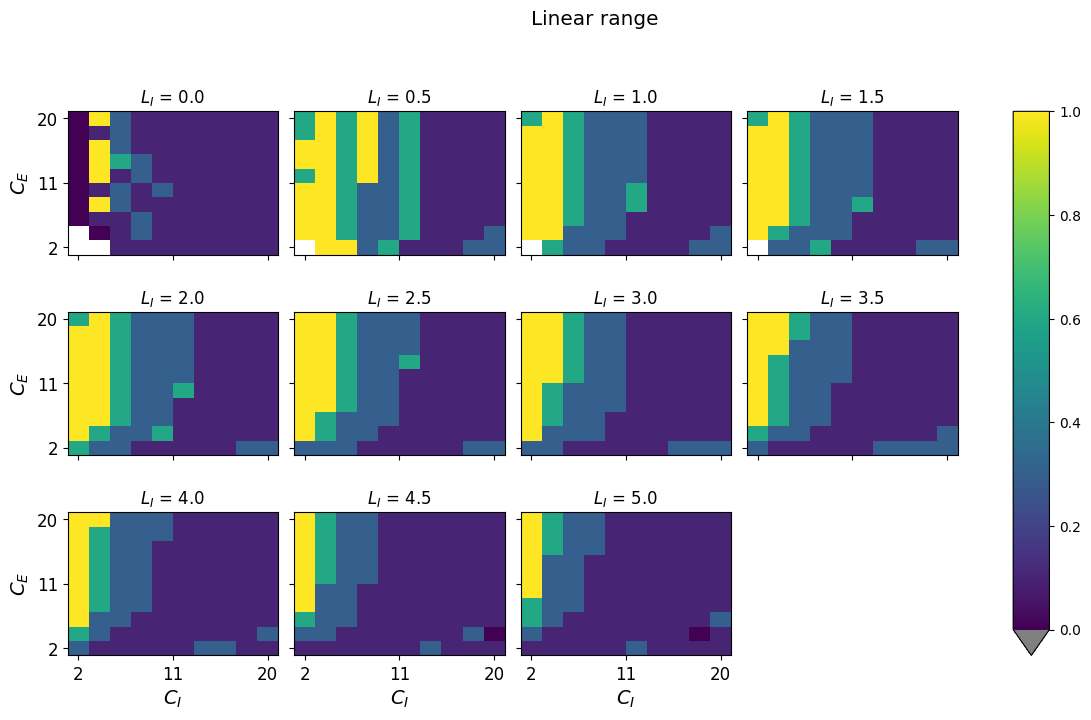

In [10]:
stable_mov_range, stable_mov_range_id, linear_mov_range, linear_mov_range_id = \
    cal_linear_range(network_eval_moving, Vels, inputs, valid_index_s)
linear_range_plot = oned2colormesh_3par(linear_mov_range[:,1], search_pars, network_pars, parnames=['CI','CE','LI'], zero2nan=False)
fig = plot_3par_on_prop(search_pars, linear_range_plot, nrow=3, ncol=4, figsizemag=3, parnames=['CI', 'CE', 'LI'], \
                        figtitle='Linear range\n\n', cmap='viridis', parname_preset=['$C_I$', '$C_E$', '$L_I$'])

In [10]:
index_shape_mismatch, dev_shape_ratios, if_match = cal_lr_shape_match_loop(network_acvs_moving, valid_index_linear_move, zeroid)
print(f'{len(index_shape_mismatch)/len(valid_index_linear_move) * 100:.2f} % = Percent of shape not match')
print(f'{np.mean(dev_shape_ratios):.2e} = Mean[(acv dif) / (max one neighboring acv dif)]')
print(f'{np.std(dev_shape_ratios):.2e} = SD[(acv dif) / (max one neighboring acv dif)]')
print(f'{np.max(dev_shape_ratios):.2e} = Max[(acv dif) / (max one neighboring acv dif)]')

0.00 % = Percent of shape not match
1.18e-06 = Mean[(acv dif) / (max one neighboring acv dif)]
2.02e-05 = SD[(acv dif) / (max one neighboring acv dif)]
1.17e-03 = Max[(acv dif) / (max one neighboring acv dif)]


In [11]:
index_shape_mismatch, dev_shape_ratios, if_match = cal_central_shape_match_loop(network_acvs_moving, valid_index_linear_move, zeroid)
print(f'{len(index_shape_mismatch)/len(valid_index_linear_move) * 100:.2f} % = Percent of shape not match')
print(f'{np.mean(dev_shape_ratios):.2e} = Mean[(acv dif) / (max one neighboring acv dif)]')
print(f'{np.std(dev_shape_ratios):.2e} = SD[(acv dif) / (max one neighboring acv dif)]')
print(f'{np.max(dev_shape_ratios):.2e} = Max[(acv dif) / (max one neighboring acv dif)]')

0.00 % = Percent of shape not match
5.45e-07 = Mean[(acv dif) / (max one neighboring acv dif)]
1.30e-05 = SD[(acv dif) / (max one neighboring acv dif)]
8.94e-04 = Max[(acv dif) / (max one neighboring acv dif)]


peak_acv, mean_acv, peak_firate, mean_firate
0.998 = All Mean[Cor: input - RL diff]
0.014 = All SD[Cor: input - RL diff]
0.680 = All Min[Cor: input - RL diff]
0.999 = Mean ACV Mean[Cor: input - RL diff]
0.006 = Mean ACV SD[Cor: input - RL diff]
0.886 = Mean ACV Min[Cor: input - RL diff]


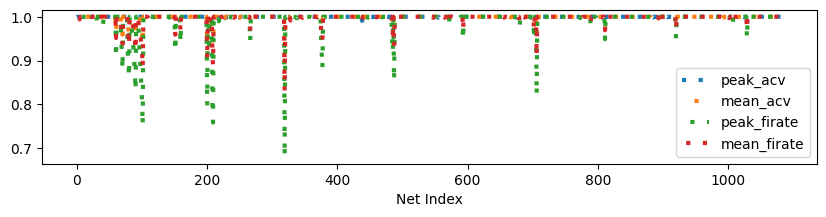

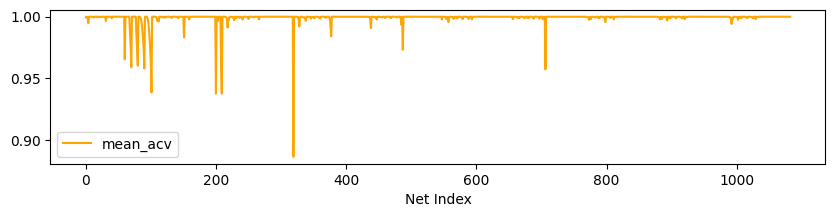

In [11]:
index_n0_linear = np.where( linear_mov_range[:,1] > 0 )[0]
bump_amplitudes = cal_firate_a_acv_mean_a_peak(network_acvs_moving, inputs, valid_index_s, [bE, bI], actfun, kind='increaseb0')
input_diff_cors, input_diff_ps = cal_input_diff_cor(inputs, bump_amplitudes[4:], index_n0_linear, linear_mov_range_id)
cor_stat_print_all(input_diff_cors, index_n0_linear)
plot_cor(input_diff_cors, index_n0_linear)
plot_mean_dif_cor(input_diff_cors, index_n0_linear)

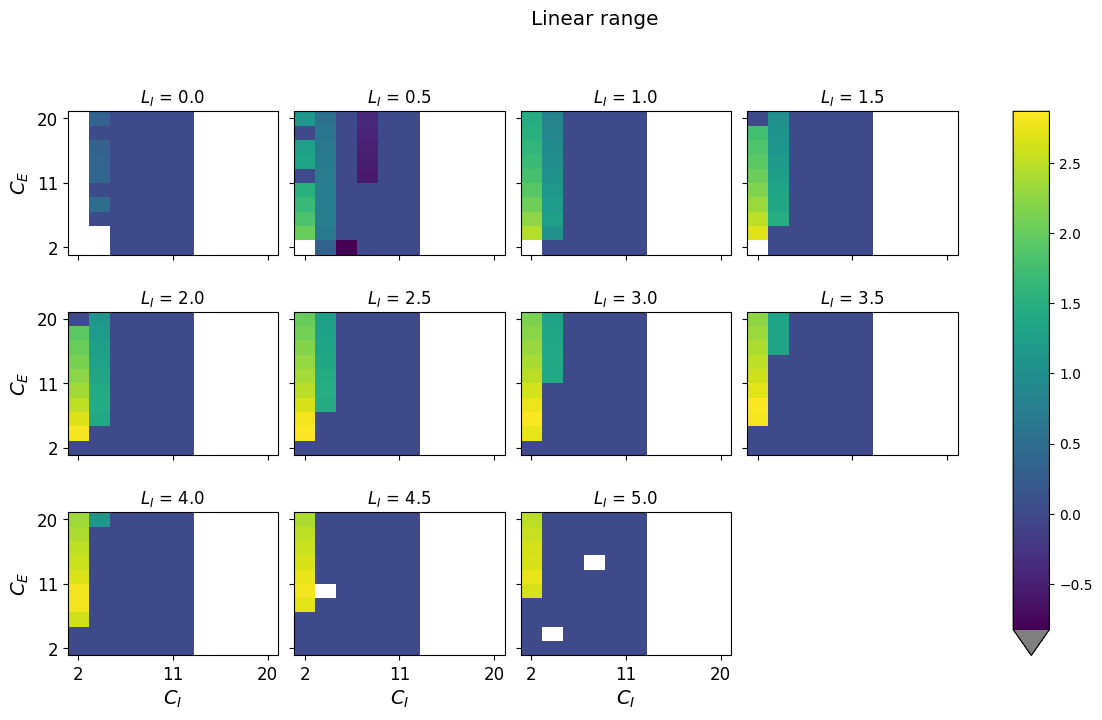

In [13]:
valid_index_not_stable_move = np.where(~np.isin(network_eval_moving_sum, ('linear moving', 'mid-linear moving', 'nonlinear moving')))[0]
slope[valid_index_not_stable_move,0,0] = np.nan
linear_range_plot = oned2colormesh_3par(slope[:,0,0], search_pars, network_pars, parnames=['CI','CE','LI'], zero2nan=False)
fig = plot_3par_on_prop(search_pars, linear_range_plot, nrow=3, ncol=4, figsizemag=3, parnames=['CI', 'CE', 'LI'], \
                        figtitle='Linear range\n\n', cmap='viridis', parname_preset=['$C_I$', '$C_E$', '$L_I$'])

# Overview

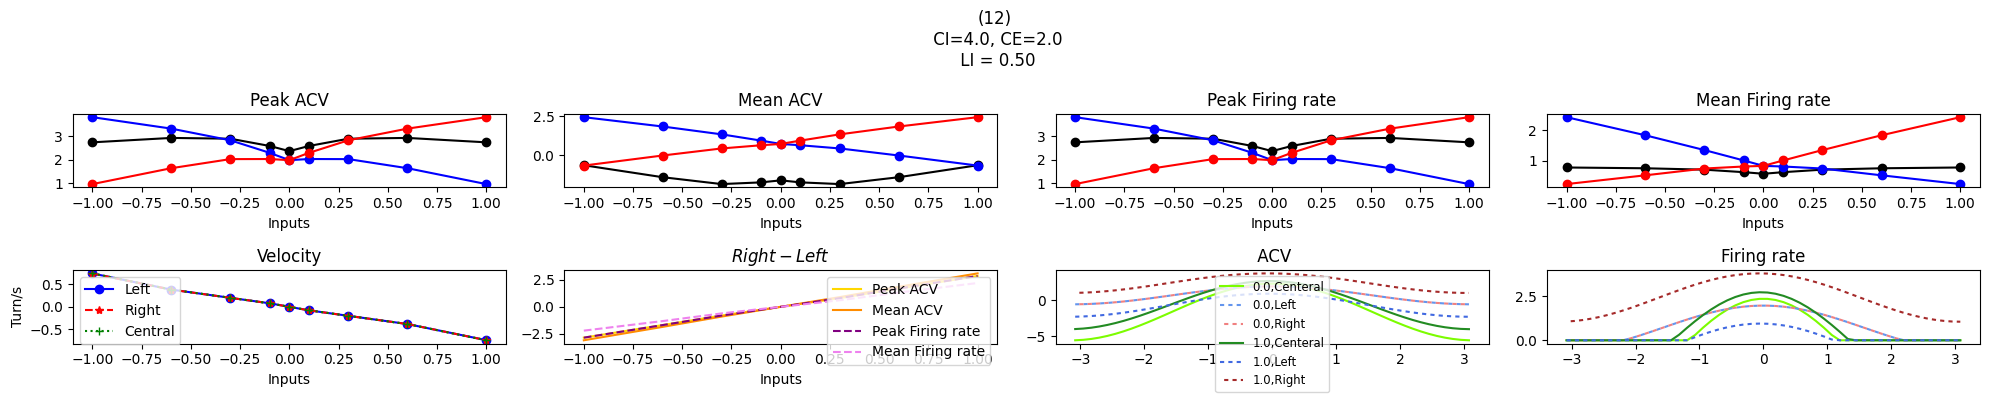

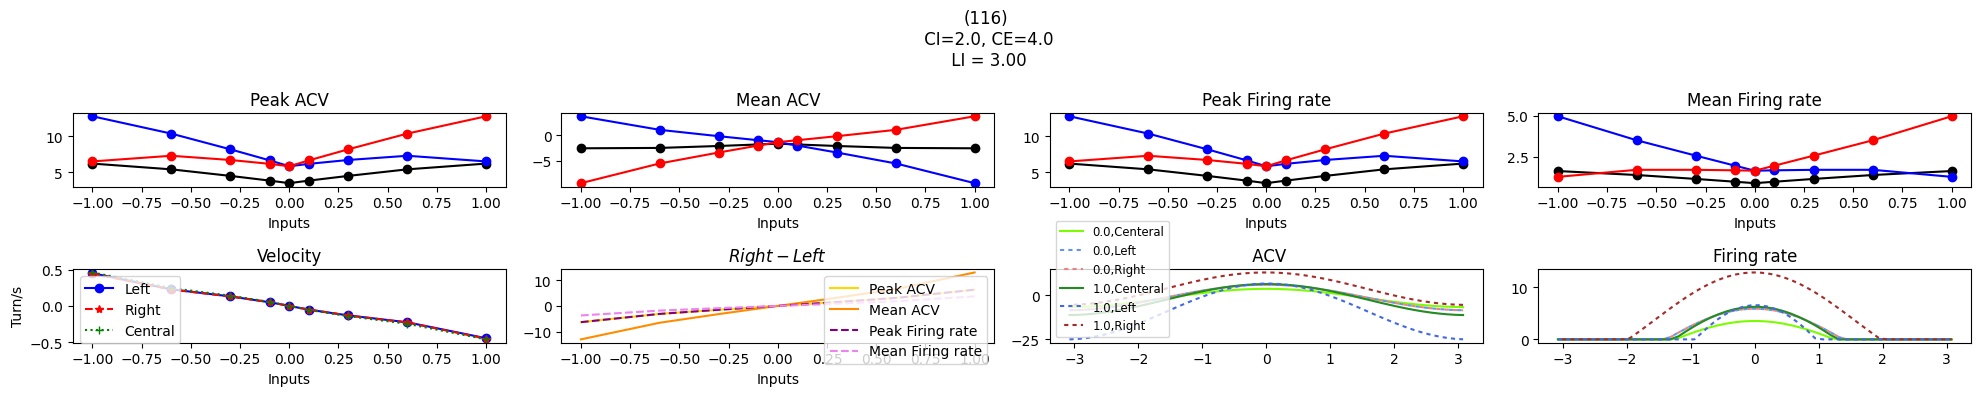

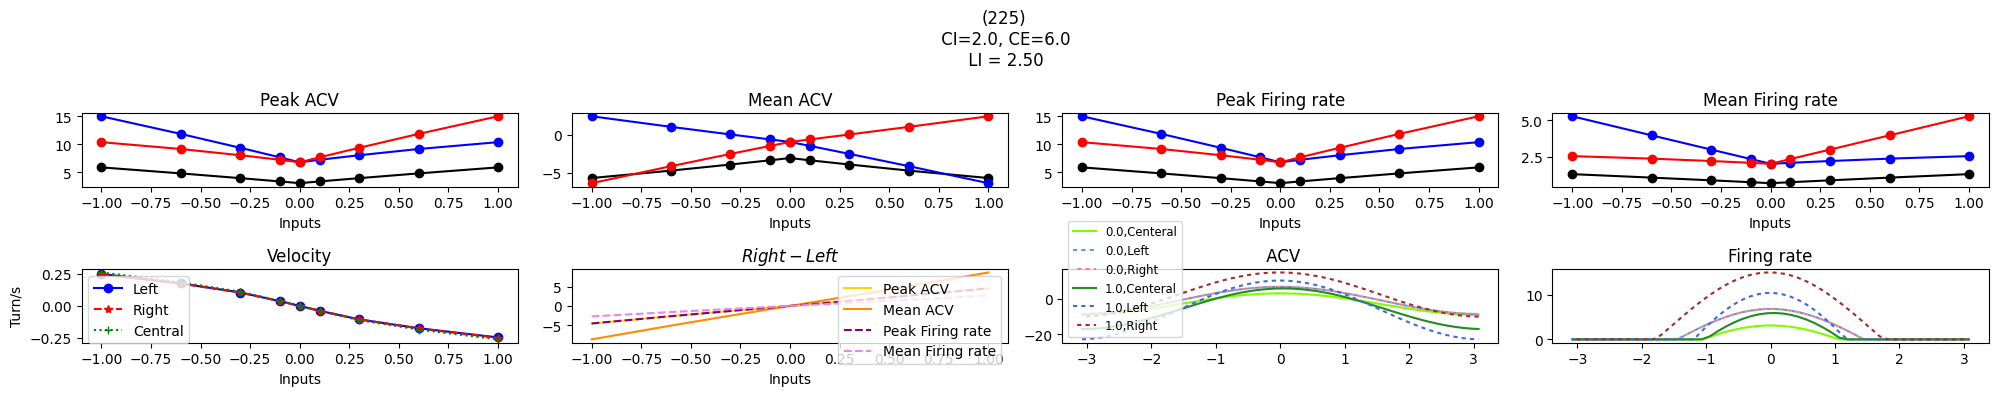

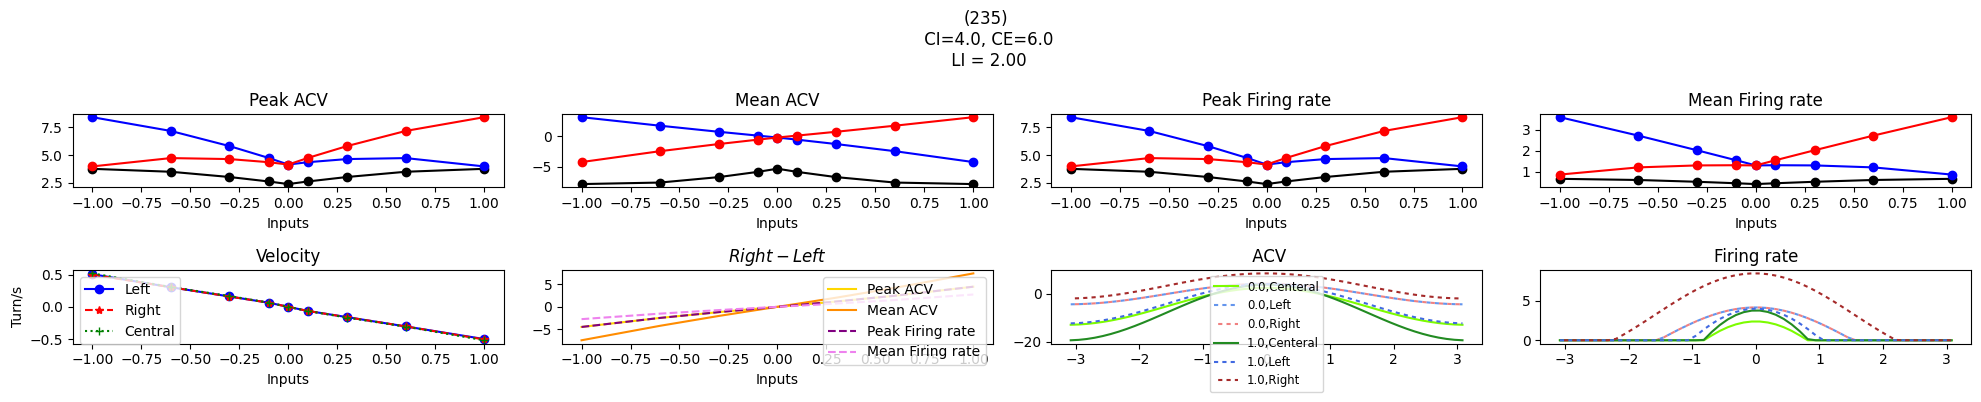

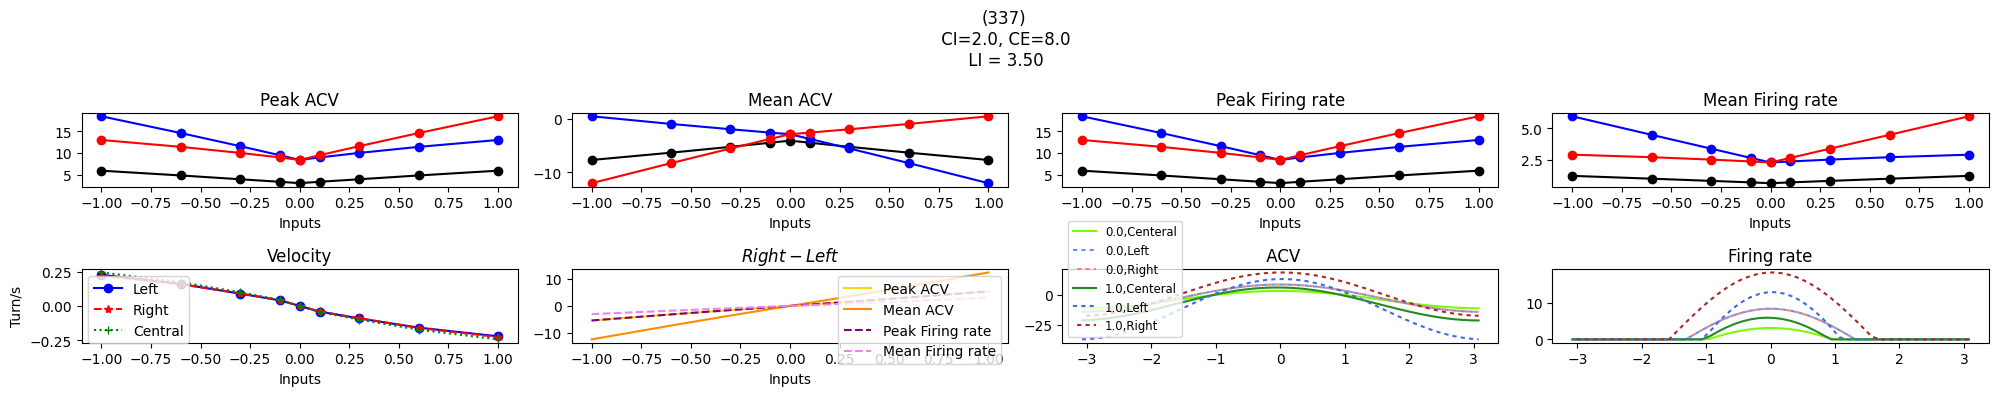

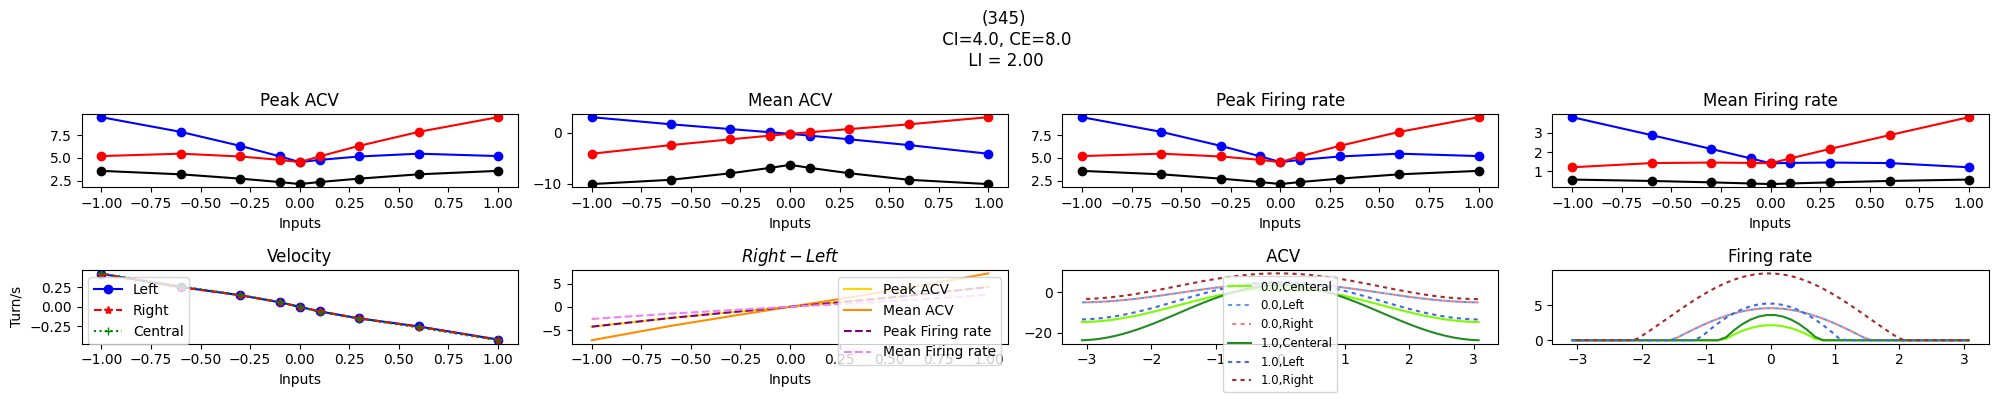

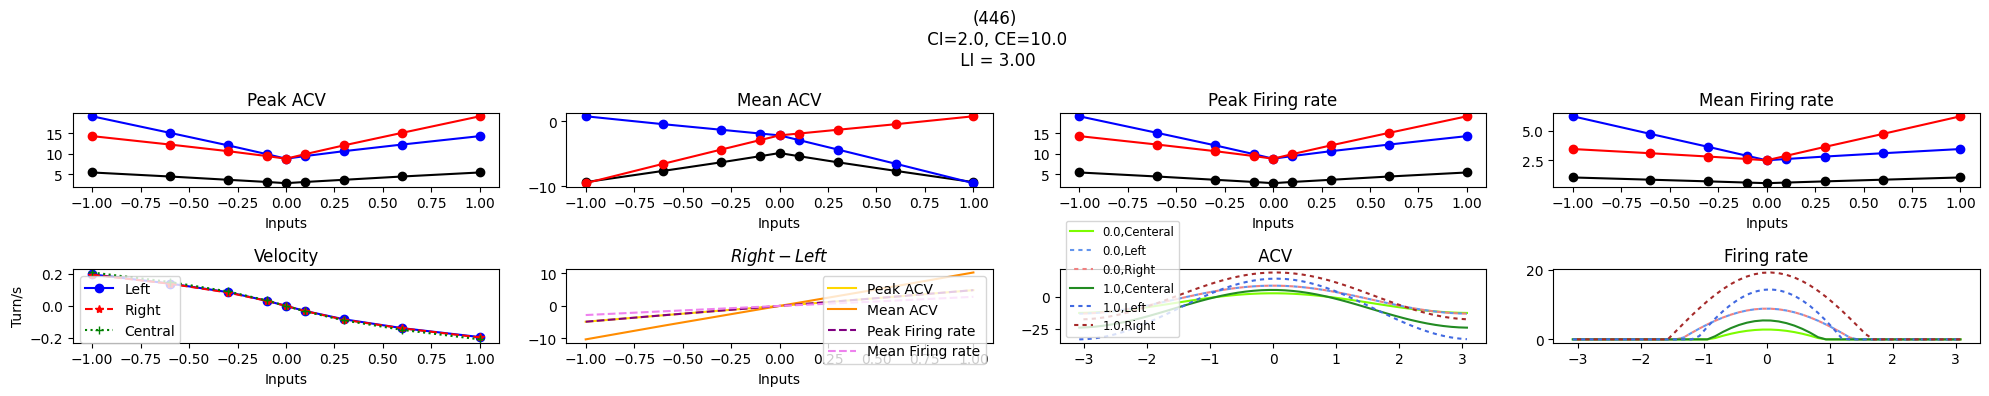

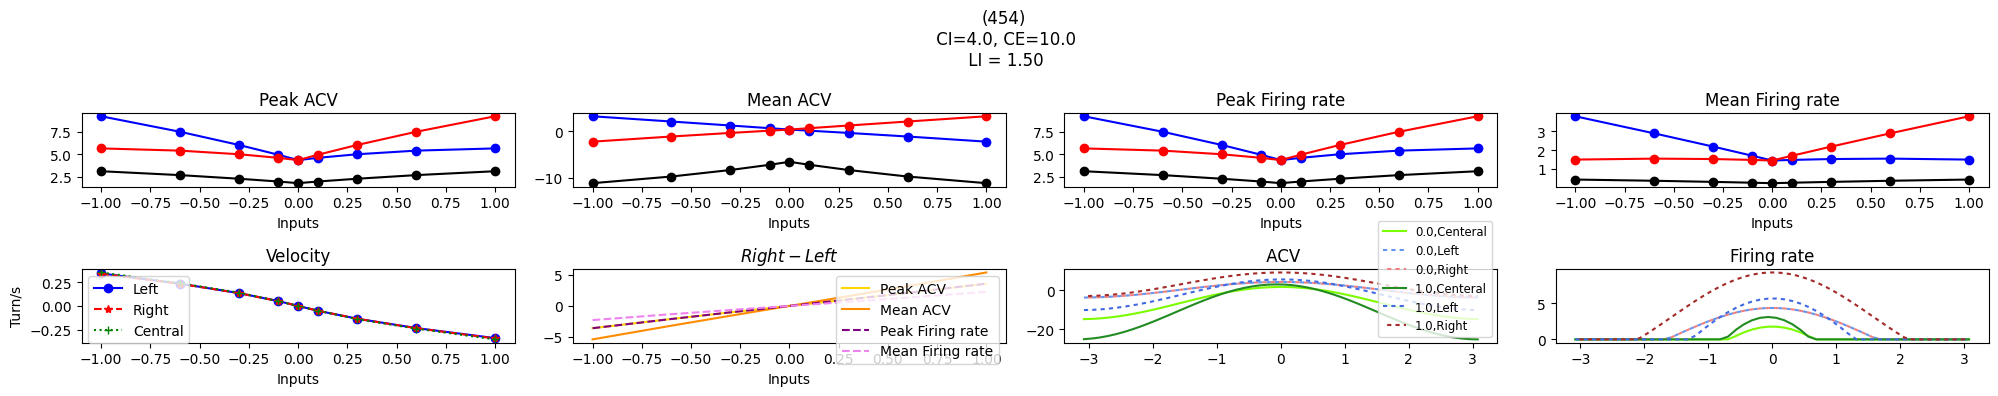

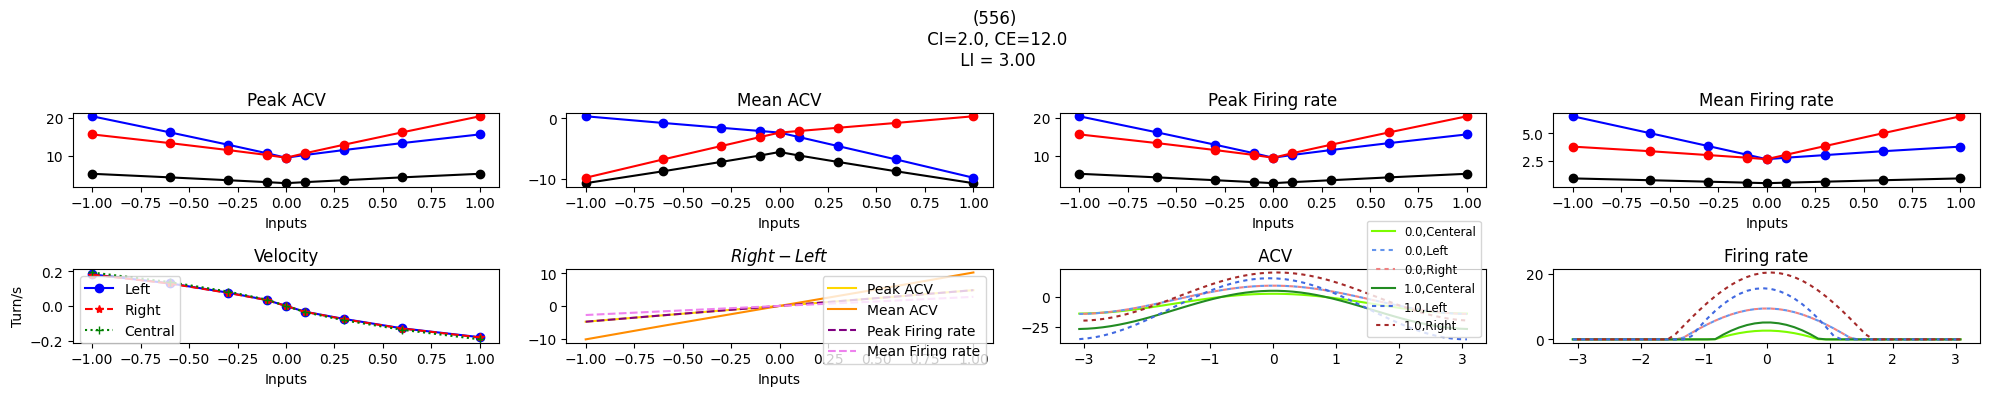

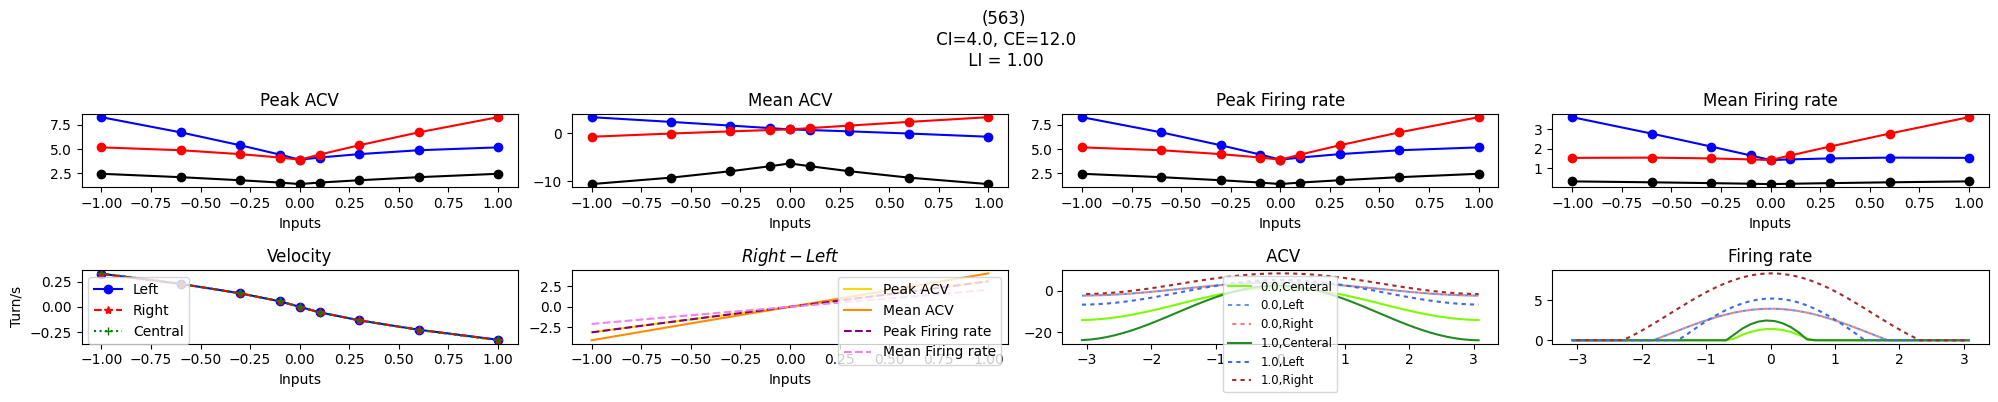

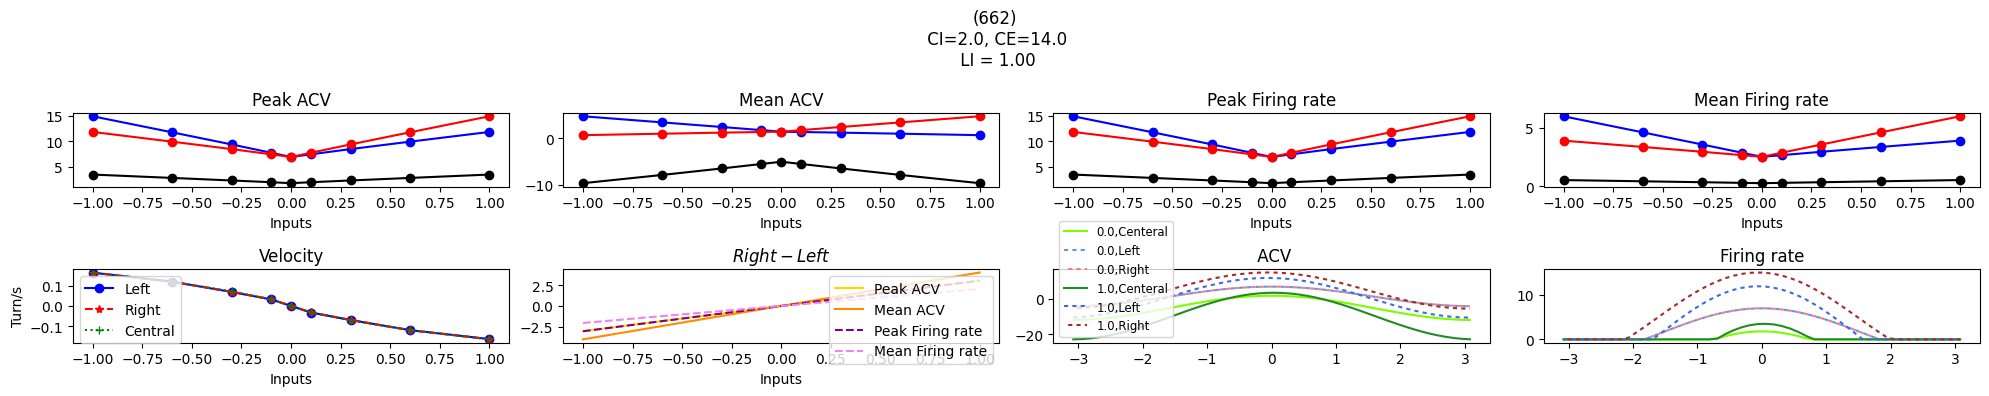

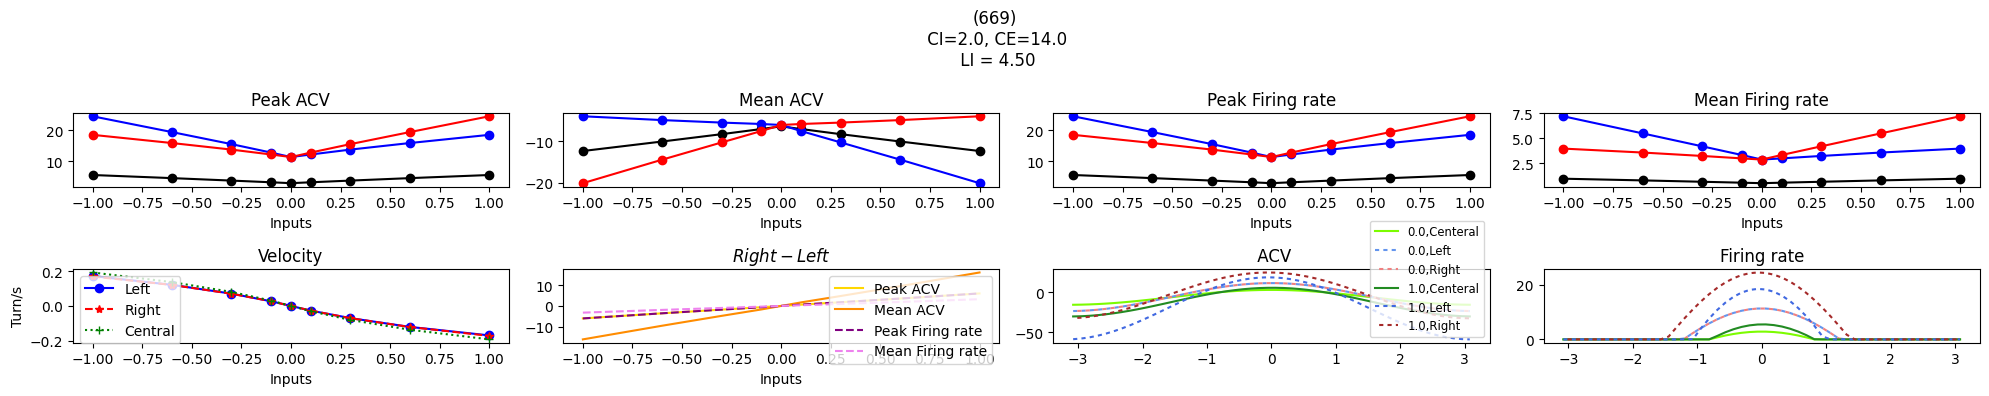

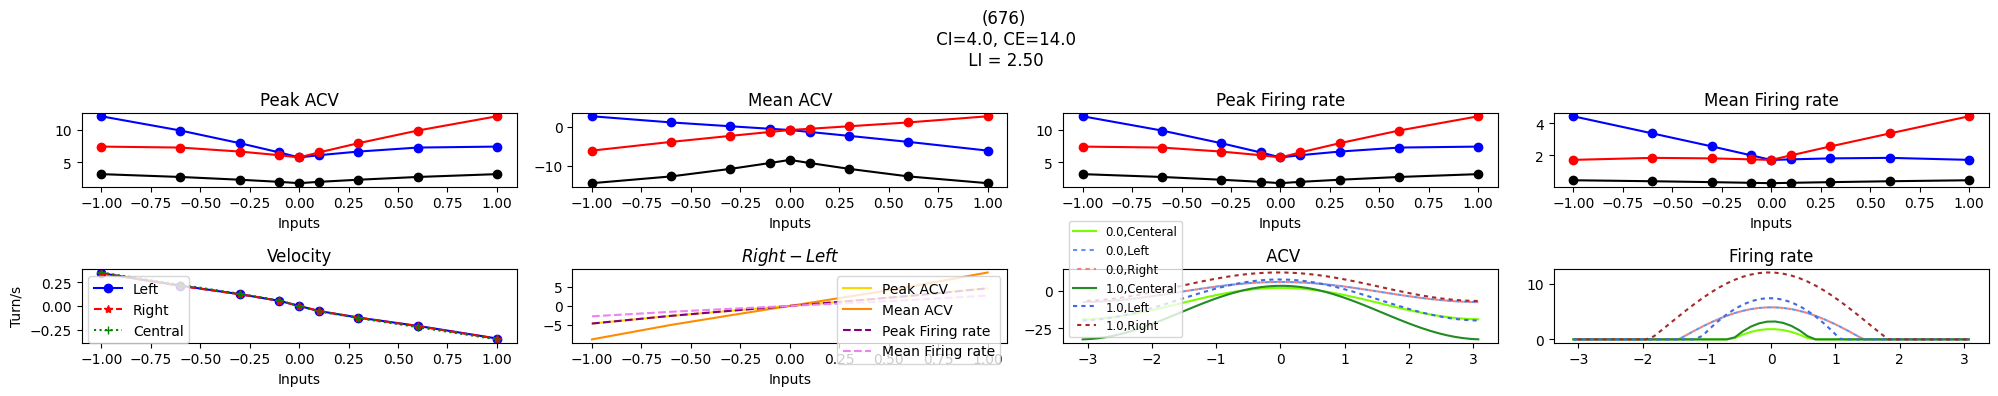

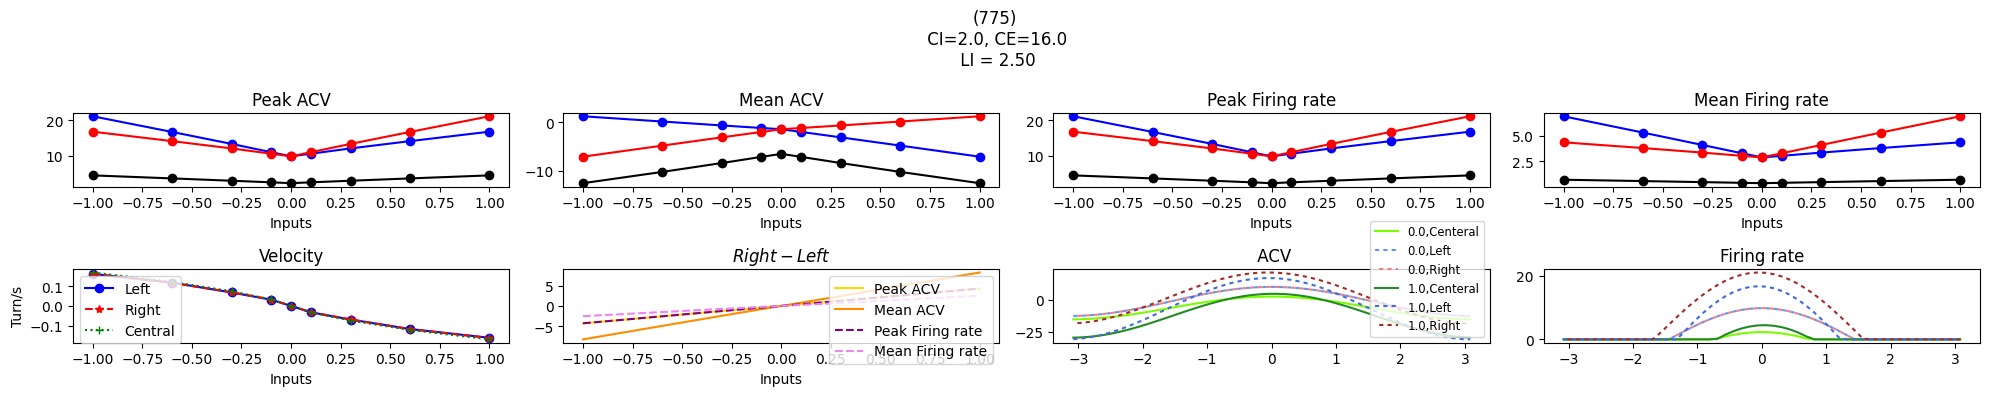

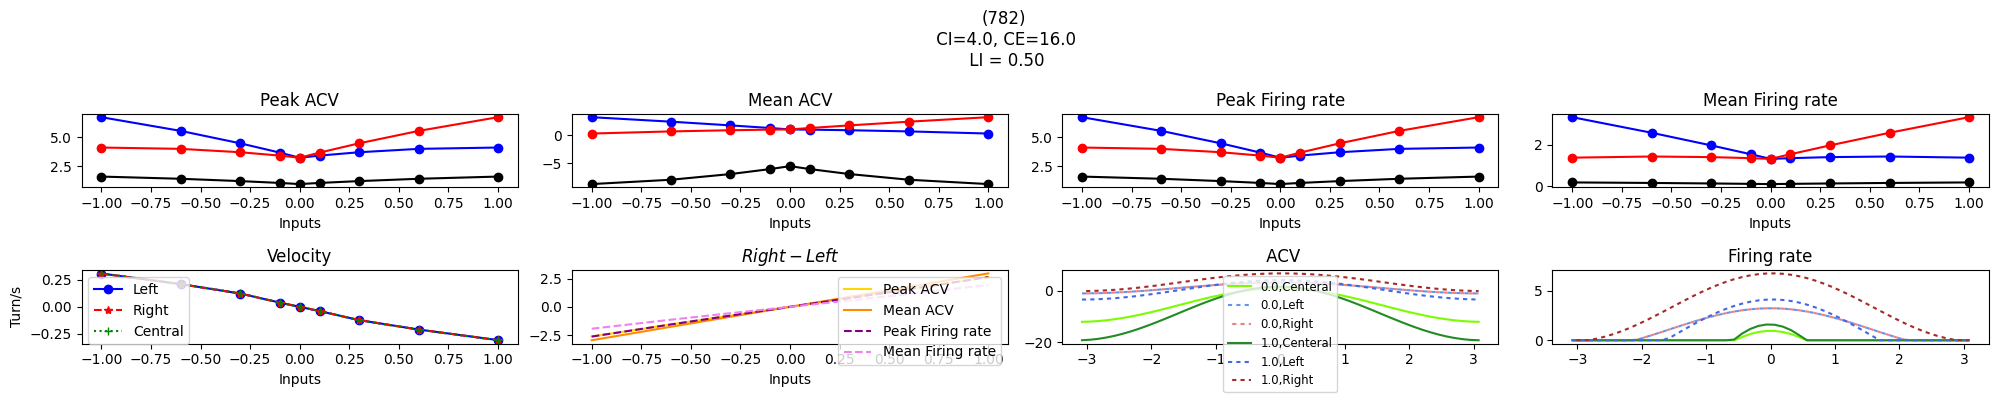

c:\users\15824\onedrive\r-hd_cell\hd_project\src\utilities\main\HD_utils\plot.py:1505: RuntimeWarning: invalid value encountered in cast
  shiftv = np.rint(cstat.mean(theta_range, f) / (2*np.pi) * len(theta_range)).astype(int)
c:\users\15824\onedrive\r-hd_cell\hd_project\src\utilities\main\HD_utils\plot.py:1506: RuntimeWarning: overflow encountered in scalar negative
  f = np.roll(f, -shiftv)


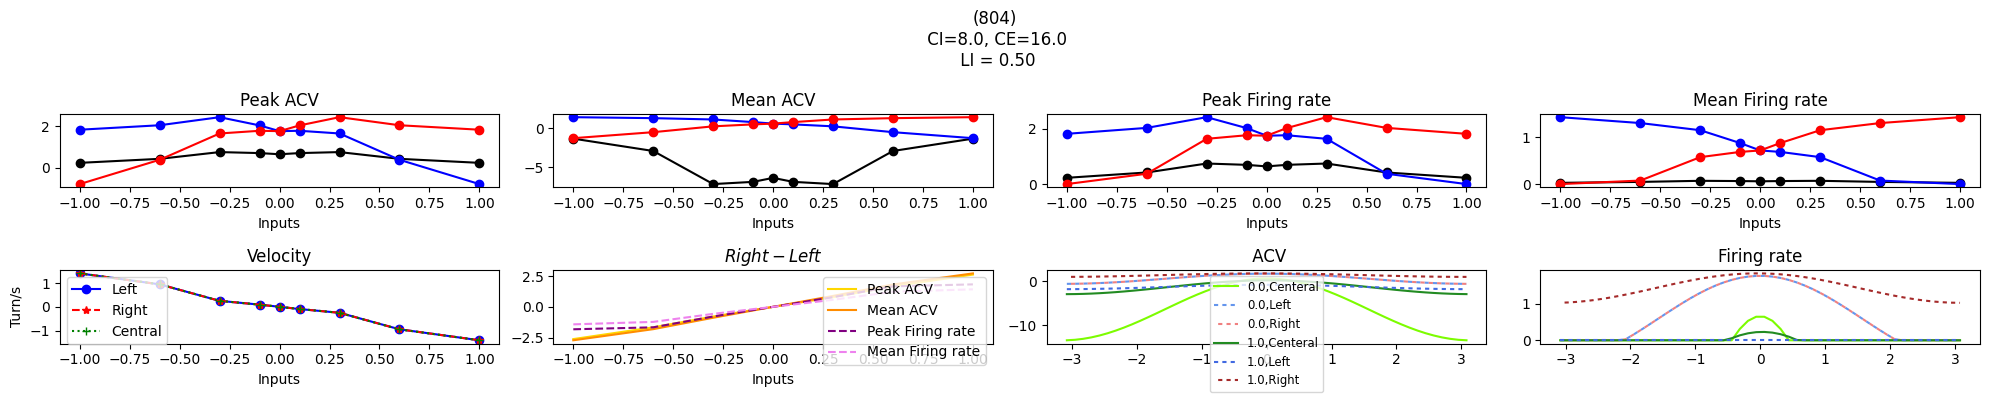

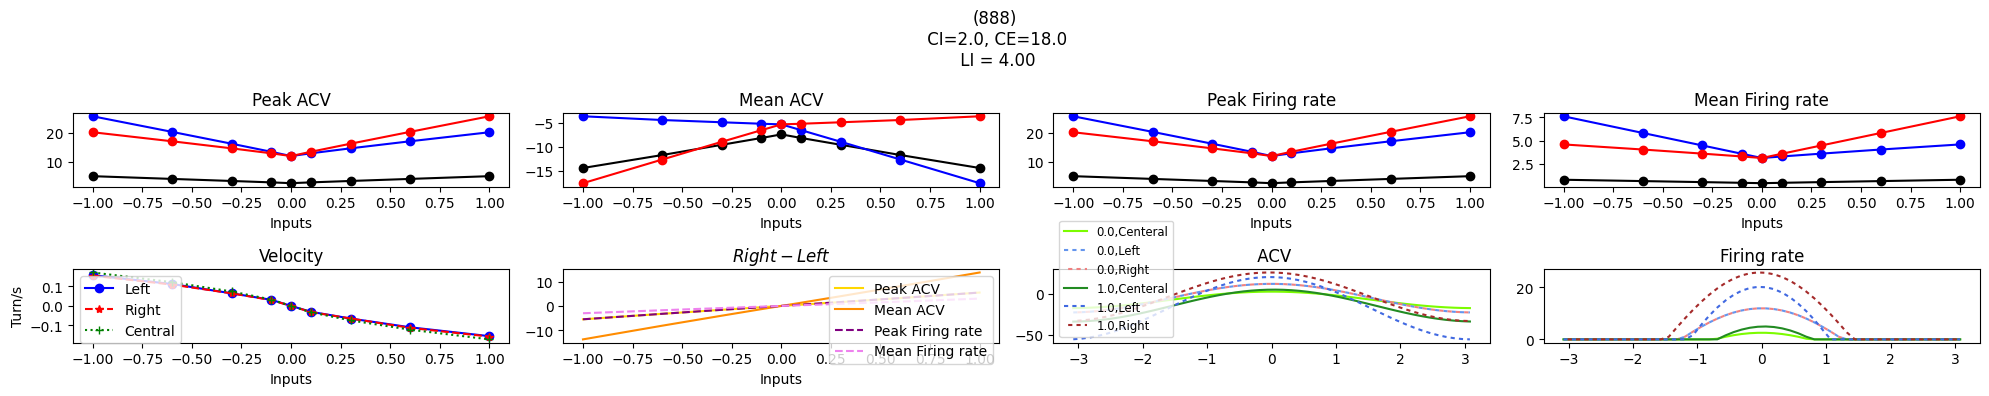

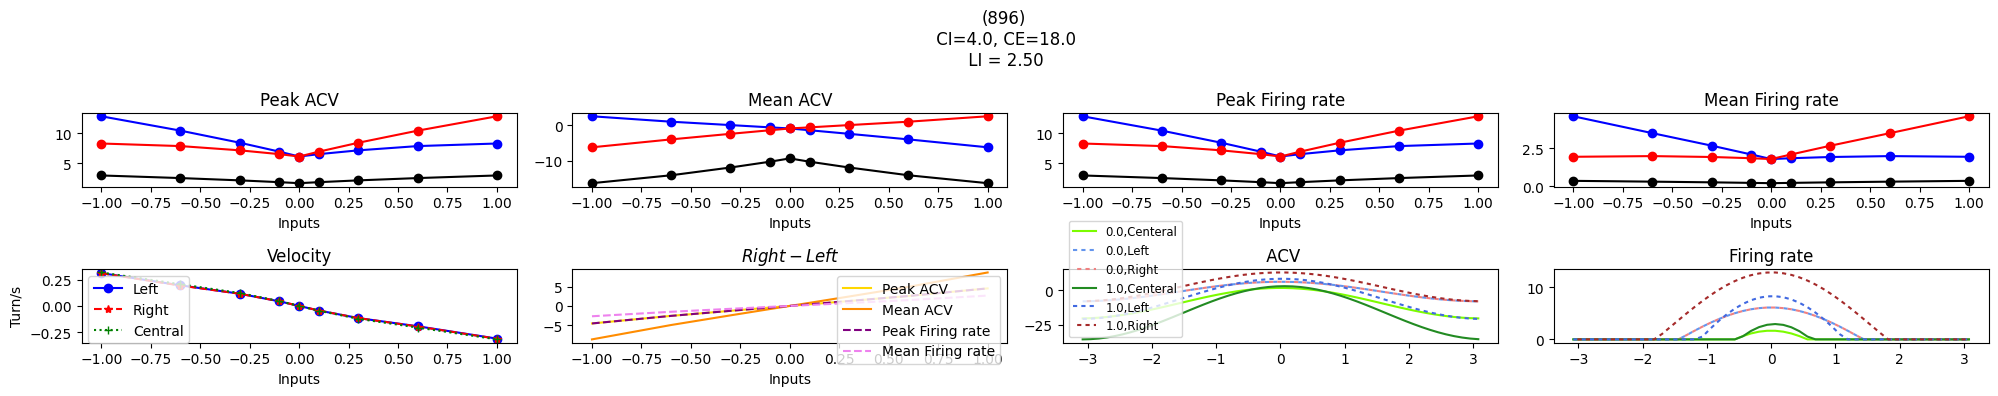

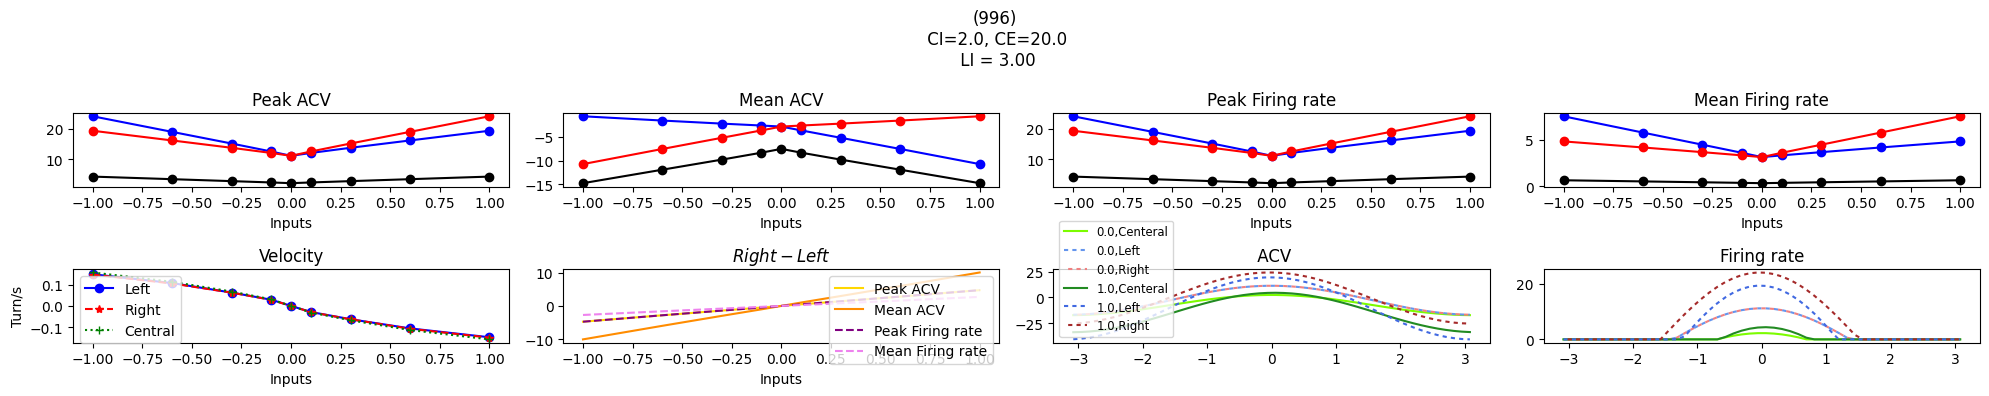

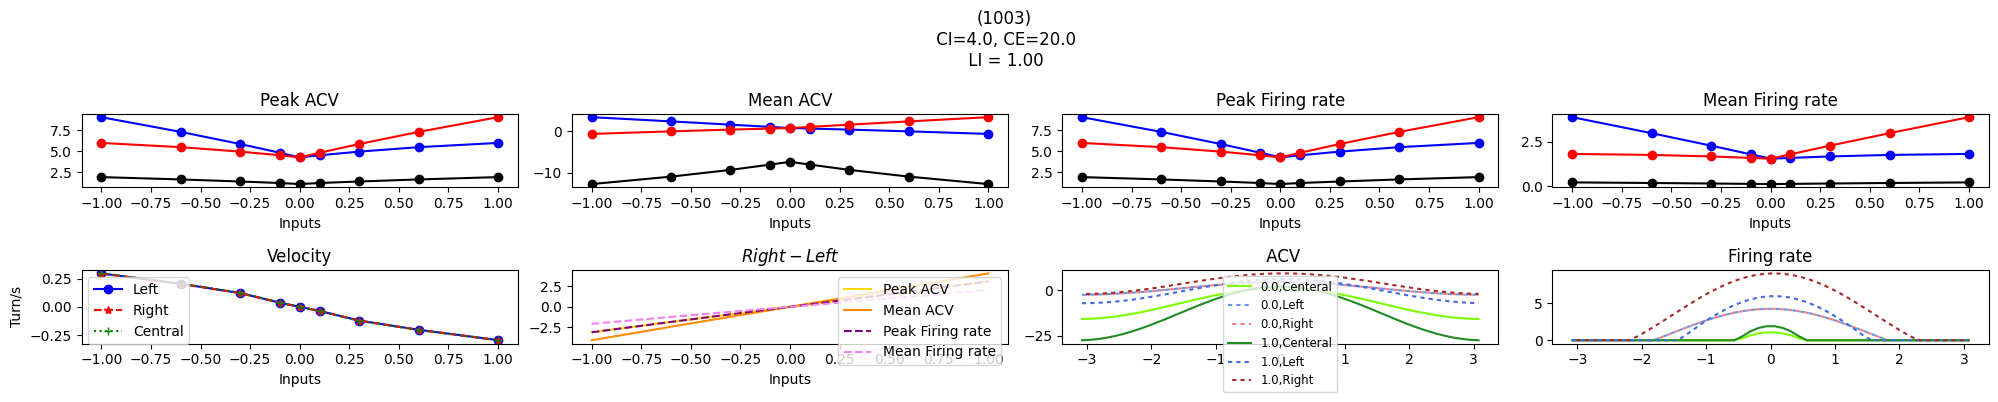

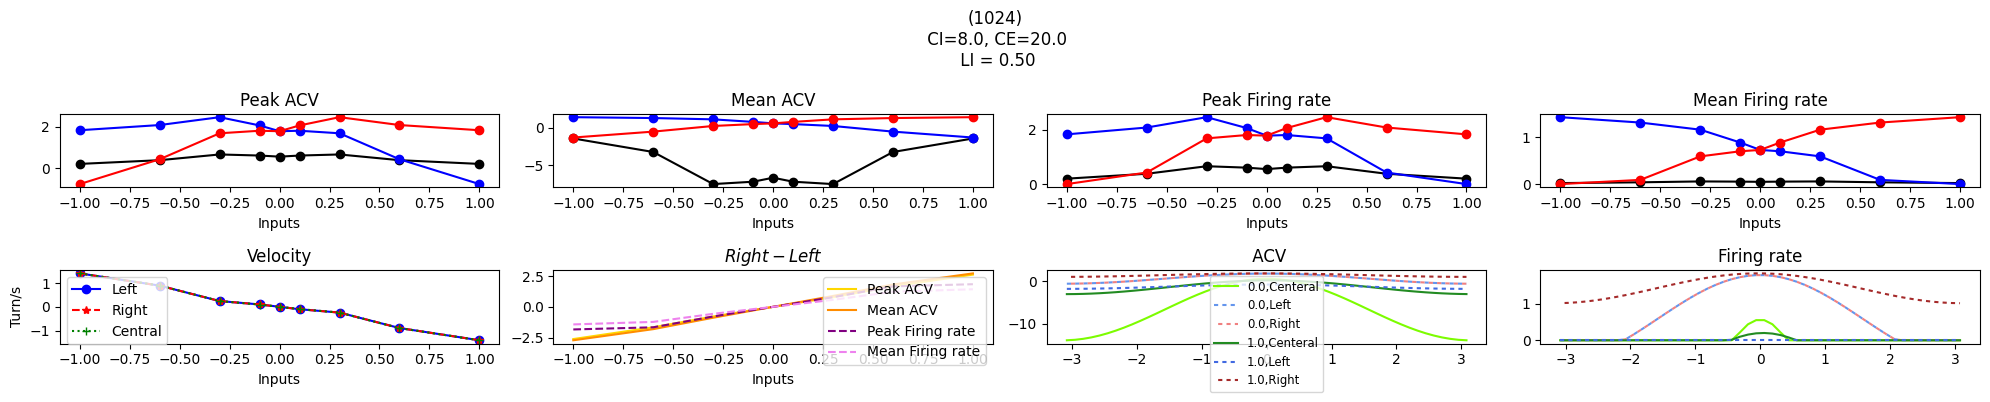

In [13]:
index_vis = valid_index_linear_move[::7]
plot_overview_25_s3ring_simple(inputs, index_vis, network_acvs_moving, network_pars, Vels, 
                               theta_range, [bE, bI], bump_amplitudes, figsize=(20,4), compare_ids=(zeroid, -1), 
                               actfun=actfun, kind='increaseb0')

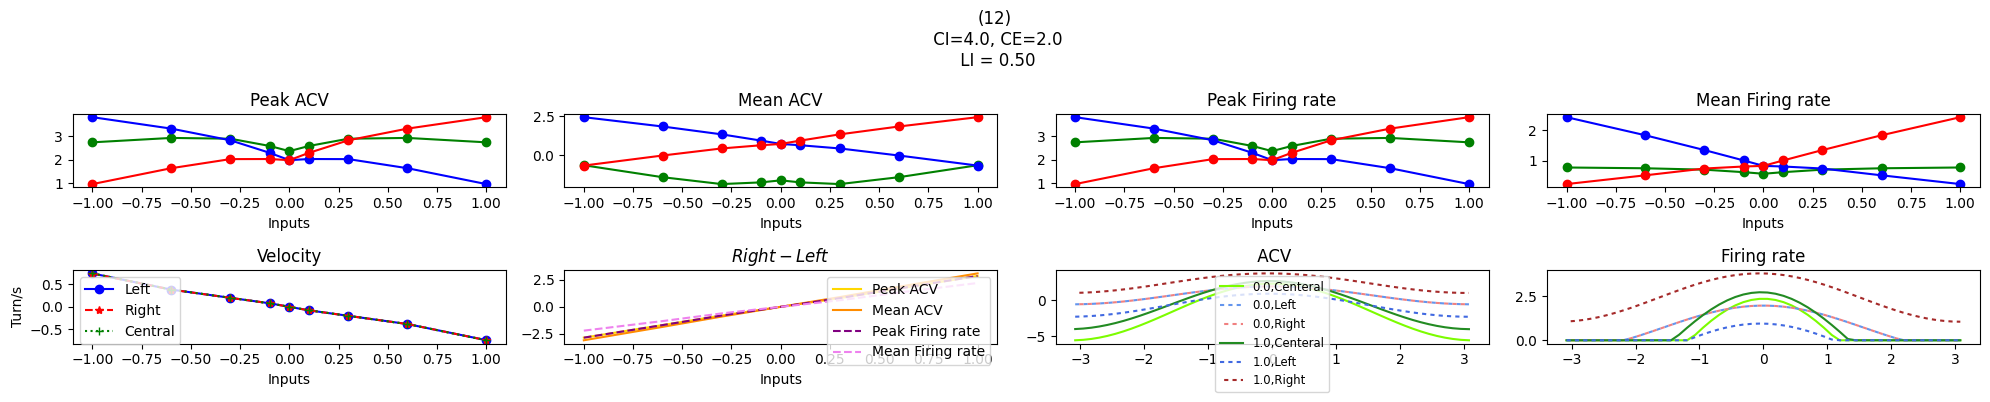

In [14]:
index_vis = np.where((slope[:,0,1] > 0) & (slope[:,1,1] > 0))[0]
plot_overview_25_s3ring_simple(inputs, index_vis, network_acvs_moving, network_pars, Vels, 
                               theta_range, [bE, bI], bump_amplitudes, figsize=(20,4), compare_ids=(zeroid, -1), 
                               actfun=actfun, kind='increaseb0')